In [38]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from scripts.plotting_functions import confidence_ellipse, myHeatmap
from scripts.preprocessor_functions import calculate_background_color
import json


In [6]:
IMAGE_DIRS = [
    #r"C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Graphene\Set3_no_Duplicates_Phillip\Images_no_vignette",
    r"C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Archive\Graphene\Set2_no_Duplicates_Concatted\Images_no_vignette",
]
MASK_DIRS = [
    #r"C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Graphene\Set3_no_Duplicates_Phillip\Masks",
    r"C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Archive\Graphene\Set2_no_Duplicates_Concatted\Mask_Human_annot",
]

COLOR_NAMES = ["Blue", "Green", "Red"]

PLOT_SAVE_DIR = "Plots_Together"
PARAM_DIR = "Parameters"
COMPONENT_COLORS = cm.get_cmap("tab20")(np.linspace(0, 1, 20))

In [7]:
MASK_PATHS = []
IMAGE_PATHS = []
IMAGE_LABELS = []

for i in range(len(IMAGE_DIRS)):

    MASK_DIR = MASK_DIRS[i]
    IMAGE_DIR = IMAGE_DIRS[i]

    TEMP_MASK_NAMES = [name for name in os.listdir(MASK_DIR) if name.endswith(".png")]
    TEMP_IMAGE_NAMES = [
        name.replace("Mask_", "")
        for name in os.listdir(MASK_DIR)
        if name.endswith(".png")
    ]

    TEMP_MASK_PATHS = [os.path.join(MASK_DIR, name) for name in TEMP_MASK_NAMES]
    TEMP_IMAGE_PATHS = [os.path.join(IMAGE_DIR, name) for name in TEMP_IMAGE_NAMES]

    MASK_PATHS.extend(TEMP_MASK_PATHS)
    IMAGE_PATHS.extend(TEMP_IMAGE_PATHS)
    IMAGE_LABELS.extend([i] * len(TEMP_IMAGE_PATHS))


In [8]:
full_colors = []
full_contrasts = []
background_colors = []
labels = []

for (m_path, i_path) in zip(MASK_PATHS, IMAGE_PATHS):
    mask = cv2.imread(m_path, 0)

    mask = cv2.erode(mask, np.ones((3, 3)), iterations=3)

    if cv2.countNonZero(mask) < 100:
        continue

    image = cv2.imread(i_path)

    flake_color = np.array(image[mask == 255])

    # extracting the contrast of the flake
    background_color = np.array(calculate_background_color(image))

    if background_color.any() == 0:
        print(i_path)
        continue

    if background_color[1] < 90:
        continue

    contrasted_image = (image / background_color) - 1
    flake_contrast = np.array(contrasted_image[mask == 255])

    background_colors.append(background_color)
    full_colors.extend(flake_color)
    full_contrasts.extend(flake_contrast)
    labels.extend([IMAGE_LABELS[IMAGE_PATHS.index(i_path)]] * len(flake_contrast))

full_colors = np.array(full_colors)
background_colors = np.array(background_colors)
full_contrasts = np.array(full_contrasts)
labels = np.array(labels)

print(len(full_contrasts))
print(len(background_colors))


C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Archive\Graphene\Set2_no_Duplicates_Concatted\Images_no_vignette\214dc5cf-ee11-4efd-9a04-dd8baf7cec02.png
2004731
359


In [11]:
# cropping the contrast array
lower_bounds = [-0.5, -0.65, -0.62]  # B,G,R
lower_bounds = [-1, -1, -1]  # B,G,R
upper_bounds = [0, -0.1, -0.1]  # B,G,R
upper_bounds = [0, 0, 0]  # B,G,R

labels = labels[
    (full_contrasts[:, 0] > lower_bounds[0])
    & (full_contrasts[:, 0] < upper_bounds[0])
    & (full_contrasts[:, 1] > lower_bounds[1])
    & (full_contrasts[:, 1] < upper_bounds[1])
    & (full_contrasts[:, 2] > lower_bounds[2])
    & (full_contrasts[:, 2] < upper_bounds[2])
]

full_contrasts = full_contrasts[
    (full_contrasts[:, 0] > lower_bounds[0])
    & (full_contrasts[:, 0] < upper_bounds[0])
    & (full_contrasts[:, 1] > lower_bounds[1])
    & (full_contrasts[:, 1] < upper_bounds[1])
    & (full_contrasts[:, 2] > lower_bounds[2])
    & (full_contrasts[:, 2] < upper_bounds[2])
]

print(len(full_contrasts))


1998065


In [17]:
# First read them in

with open(f"{PARAM_DIR}/old_graphene.json", "r") as f:
    component_dict = json.load(f)

prev_means = []
prev_color_radius = []

for component in component_dict:
    contrasts = [
        component_dict[component]["contrast"]["b"],
        component_dict[component]["contrast"]["g"],
        component_dict[component]["contrast"]["r"],
    ]
    color_radius = [
        component_dict[component]["color_radius"]["b"],
        component_dict[component]["color_radius"]["g"],
        component_dict[component]["color_radius"]["r"],
    ]
    
    prev_means.append(contrasts)
    prev_color_radius.append(color_radius)

prev_means = np.array(prev_means)
prev_color_radius = np.array(prev_color_radius)

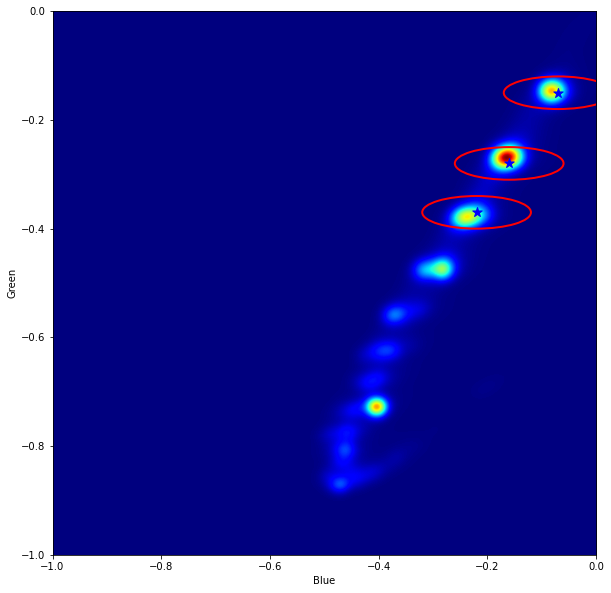

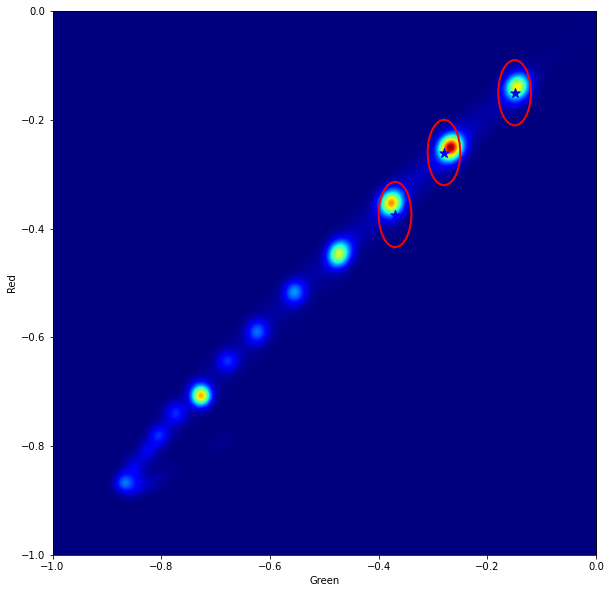

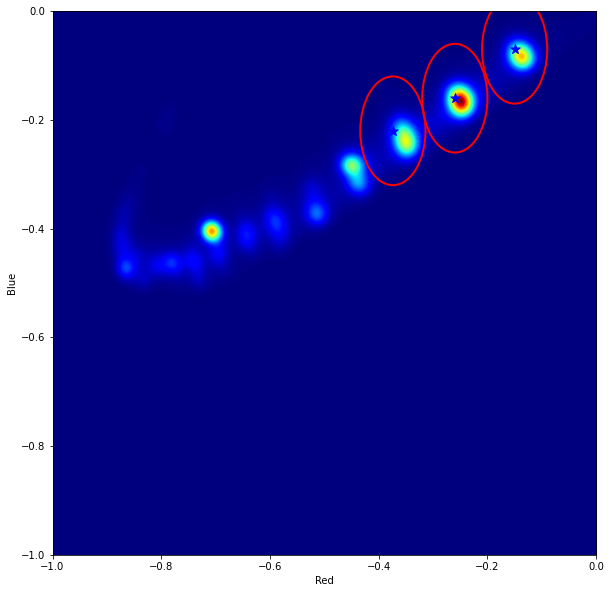

In [39]:

for i in [0, 1, 2]:

    x_lower = lower_bounds[i]
    x_upper = upper_bounds[i]
    y_lower = lower_bounds[(i + 1) % 3]
    y_upper = upper_bounds[(i + 1) % 3]

    X_DATA = full_contrasts[:, [i, (i + 1) % 3]]
    gauss_means = prev_means[:, [i, (i + 1) % 3]]
    color_radius = prev_color_radius[:, [i, (i + 1) % 3]]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    img, extent = myHeatmap(
        X_DATA[:, 0],
        X_DATA[:, 1],
        10,
        bins=1000,
        extent=[x_lower, x_upper, y_lower, y_upper],
    )
    plt.imshow(img, extent=extent, origin="lower", cmap=cm.jet)

    plt.xlabel(COLOR_NAMES[i])
    plt.ylabel(COLOR_NAMES[(i + 1) % 3])

    # add the confidence ellipse
    for j in range(len(prev_means)):
        x_mean = gauss_means[j, 0]
        y_mean = gauss_means[j, 1]
        ellipse = Ellipse(
            (x_mean, y_mean),
            width=color_radius[j,0] * 2,
            height=color_radius[j,1] * 2,
            linewidth=2,
            facecolor="none",
            edgecolor="red",
        )
        ax.add_patch(ellipse)

    plt.scatter(gauss_means[:, 0], gauss_means[:, 1], s=100, marker="*", c="b")

    # plt.legend()
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    plt.xlabel(COLOR_NAMES[i])
    plt.ylabel(COLOR_NAMES[(i + 1) % 3])
    plt.savefig(
        f"{PLOT_SAVE_DIR}/HEAT_{COLOR_NAMES[i]}_{COLOR_NAMES[(i + 1) % 3]}_old.jpg", dpi=500
    )
    plt.show()


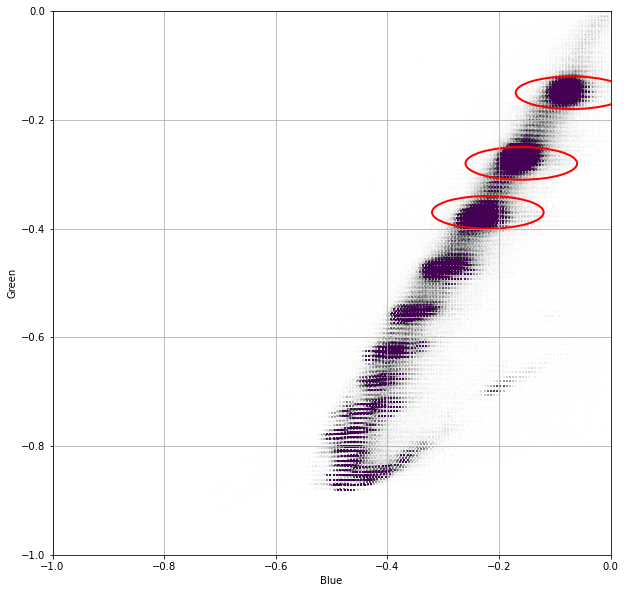

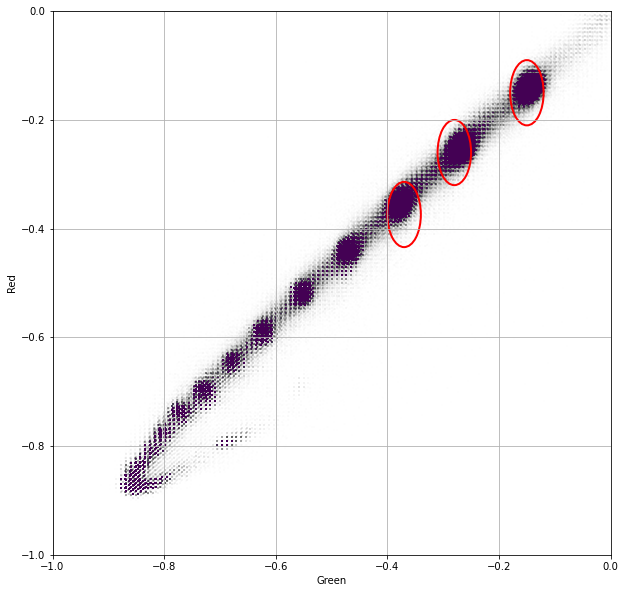

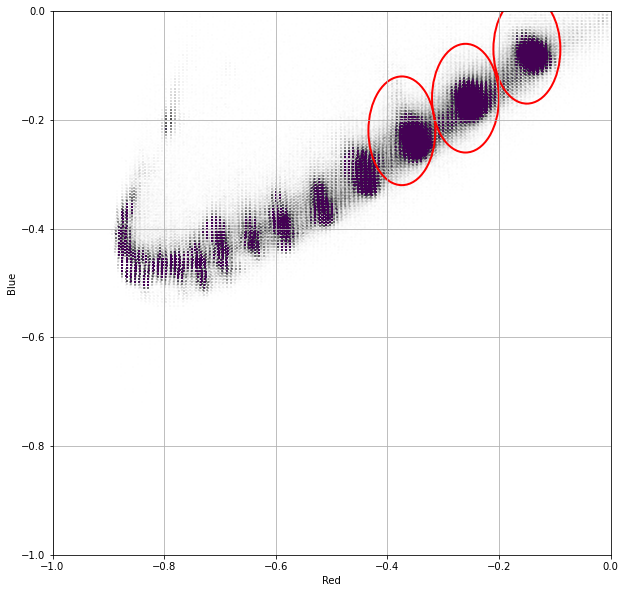

In [40]:
for i in range(3):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    x_lower = lower_bounds[i]
    x_upper = upper_bounds[i]
    y_lower = lower_bounds[(i + 1) % 3]
    y_upper = upper_bounds[(i + 1) % 3]

    gauss_means = prev_means[:, [i, (i + 1) % 3]]
    color_radius = prev_color_radius[:, [i, (i + 1) % 3]]
    X_DATA = full_contrasts[:, [i, (i + 1) % 3]]

    # increast the font size
    # plt.rcParams.update({'font.size': 20})
    
    ax.scatter(
        X_DATA[:, 0],
        X_DATA[:, 1],
        marker="s",
        s=1,
        alpha=0.004,
        c=labels,
    )

    for j in range(len(prev_means)):
        x_mean = gauss_means[j, 0]
        y_mean = gauss_means[j, 1]
        ellipse = Ellipse(
            (x_mean, y_mean),
            width=color_radius[j,0] * 2,
            height=color_radius[j,1] * 2,
            linewidth=2,
            facecolor="none",
            edgecolor="red",
        )
        ax.add_patch(ellipse)

    ax.set_xlabel(COLOR_NAMES[i])
    ax.set_ylabel(COLOR_NAMES[(i + 1) % 3])
    ax.grid()
    ax.set_xlim(x_lower, x_upper)
    ax.set_ylim(y_lower, y_upper)
    plt.savefig(f"{PLOT_SAVE_DIR}/compared_scatter_contrast_{i}_old.jpg", dpi=300)
    plt.show()
